## Imports

In [1]:
import pandas as pd
import random
from lenskit.algorithms import Recommender
from lenskit.algorithms.user_knn import UserUser
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings('ignore')

## Parameters

In [2]:
group_size = 4  # number of users in a group
test_size = 0.2  # hold out 20% of the data for testing
recommendations_number = 5  # number of recommended items
collaborative_filtering = UserUser(15, min_nbrs=3)  # collaborative filtering algorithm
approval_voting_threshold = 3.0  # threshold for approval voting strategy
binarize_feedback_positive_threshold = 4.0  # if the feedback should be binarize, this denotes the minimal positive value
inverse_propensity_gamma = 0.5  # gamma parameter of the inverse propensity weighting.

## Load Data

In [3]:
ratings = pd.read_csv('ratings.csv')
movies = pd.read_csv('movies.csv')

train, test = train_test_split(ratings, test_size=test_size, random_state=42, shuffle=True, stratify=ratings["user"])

## Train Individual Recommender

In [4]:
recsys = Recommender.adapt(collaborative_filtering)
recsys.fit(train)

Numba is using threading layer omp - consider TBB
found 1 potential runtime problems - see https://boi.st/lkpy-perf


## Generate Synthetic Groups

In [5]:
unique_users = list(ratings['user'].unique())
groups = [random.sample(unique_users, group_size) for i in range(1000)]

## Generate and Evaluate Recommendations

### Helper Functions

In [6]:
def approval_voting(a, axis=None, out=None, keepdims=np._NoValue, initial=np._NoValue, where=np._NoValue):
    return np.sum(a > approval_voting_threshold, axis=axis, out=out, keepdims=keepdims, initial=initial, where=where)


def generate_group_recommendations_for_group(group_ratings):
    aggregated_df = group_ratings.groupby('item').agg({"predicted_rating": [np.max, approval_voting]})
    aggregated_df = aggregated_df["predicted_rating"].reset_index()

    # most pleasure
    mpl_df = aggregated_df.sort_values(by="amax", ascending=False).reset_index()[['item', 'amax']]
    mpl_recommendation_list = list(mpl_df.head(recommendations_number)['item'])

    # approval voting
    apv_df = aggregated_df.sort_values(by="approval_voting", ascending=False).reset_index()[['item', 'approval_voting']]
    apv_recommendation_list = list(apv_df.head(recommendations_number)['item'])

    return {
        "most_pleasure": mpl_recommendation_list,
        "approval_voting": apv_recommendation_list
    }


def evaluateUserNDCG(user_ground_truth, group_recommendation):
    dcg = 0
    for k, item in enumerate(group_recommendation):
        dcg = dcg + ((user_ground_truth.loc[item, "final_rating"] if item in user_ground_truth.index else 0) / np.log2(
            k + 2))

    idcg = 0
    # what if intersection is empty?
    user_ground_truth.sort_values("final_rating", inplace=True, ascending=False)
    for k in range(min(len(user_ground_truth), len(group_recommendation))):
        idcg = idcg + (user_ground_truth.iloc[k]["final_rating"] / np.log2(k + 2))
    if idcg > 0:
        ndcg = dcg / idcg
    else:
        ndcg = 0

    return ndcg

### Generate and Evaluate

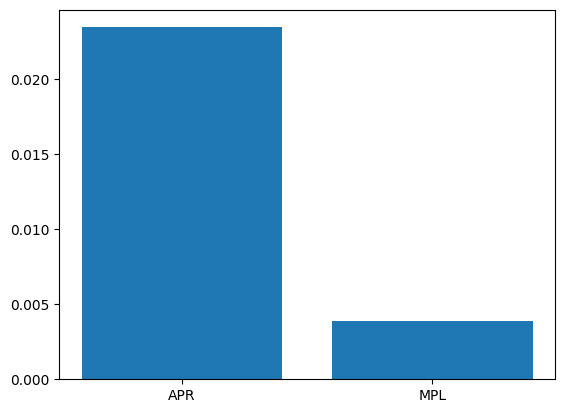

In [7]:
groups_ndcg = {
    "most_pleasure": [],
    "approval_voting": []
}

for i, group in enumerate(groups):
    group_ratings = test.loc[test['user'].isin(group)]
    group_ratings['predicted_rating'] = recsys.predict(group_ratings)
    group_recommendation = generate_group_recommendations_for_group(group_ratings)

    ground_truth = group_ratings.reset_index()[['user', 'item', 'rating']]

    group_ndcg = {
        "most_pleasure": [],
        "approval_voting": []
    }

    for user in group:
        user_ground_truth = ground_truth.loc[ground_truth['user'] == user]
        user_ground_truth['final_rating'] = 0
        user_ground_truth.loc[user_ground_truth['rating'] >= binarize_feedback_positive_threshold, 'final_rating'] = 1
        group_ndcg["approval_voting"].append(evaluateUserNDCG(user_ground_truth, group_recommendation['approval_voting']))
        group_ndcg["most_pleasure"].append(evaluateUserNDCG(user_ground_truth, group_recommendation['most_pleasure']))

    groups_ndcg["approval_voting"].append(np.mean(group_ndcg["approval_voting"]))
    groups_ndcg["most_pleasure"].append(np.mean(group_ndcg["most_pleasure"]))


plt.bar(["APR", "MPL"], [np.mean(groups_ndcg["approval_voting"]), np.mean(groups_ndcg["most_pleasure"])])
plt.show()

We can see that Approval Voting performs significantly better than Most Pleasure.